In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision

import os
import numpy as np
import librosa
import os
import torch
import torchaudio.transforms as T
import datetime
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#import own modules
import config
from utils_dir import transforms 

#empty cache
torch.cuda.empty_cache()


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")



In [17]:
if config.ESC_50:
    from DL_pretrain import ESC_50_DL_pretrain as DS
    print("ESC_50 Loaded for pretraining")
if config.US8K:
    from DL_pretrain import US8k_DL_pretrain as DS
    print("US8K Loaded for pretraining")




US8K Loaded for pretraining


In [18]:

train_dataset = DS.AudioDataset(train=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Shape of tensors in triplet 1:
Anchor:			torch.Size([1, 128, 431])
Positive:		torch.Size([1, 128, 431])
Negative:		torch.Size([1, 128, 431])
False
False


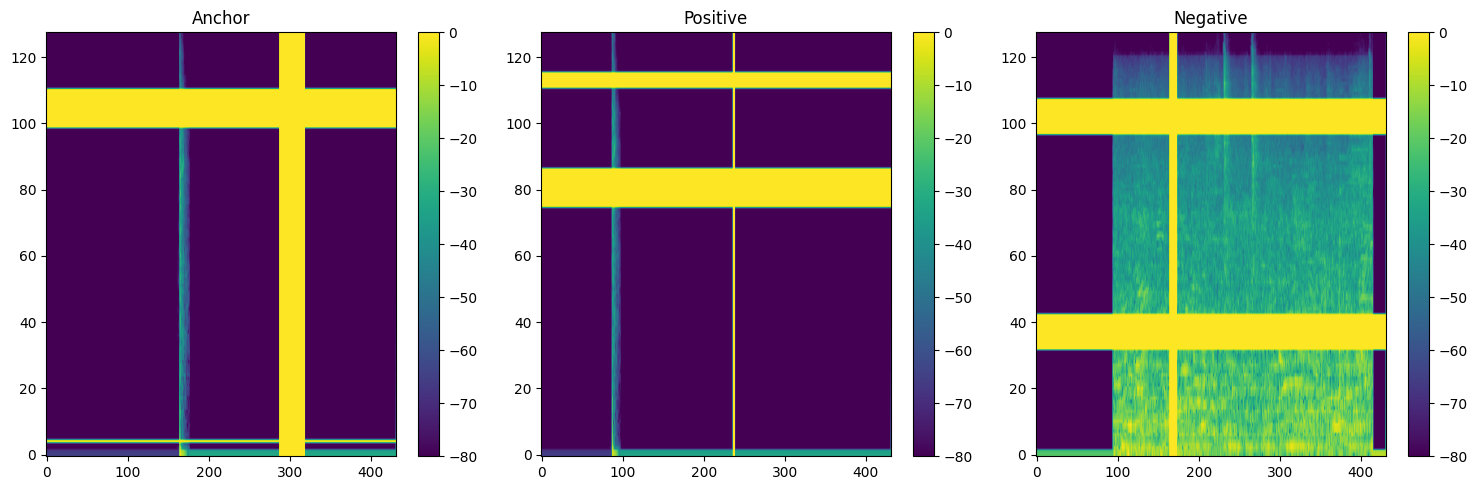

In [23]:

def plot_triplet_spectrogram(train_loader, n_triplets=1):
    """
    Plot spectrograms for anchor, positive and negative from the first batch of the given loader.
    
    Args:
    - train_loader (torch.utils.data.DataLoader): Data loader for triplet data.
    """
    # Fetch the first batch
    data_iter = iter(train_loader)
    anchor, positive, negative = data_iter.__next__()

    # Function to plot spectrogram
    def plot_spectrogram(spectrogram, ax, title):
        im = ax.imshow(spectrogram.squeeze().cpu().numpy(), aspect='auto', origin='lower')
        ax.set_title(title)
        fig.colorbar(im, ax=ax)
    
    i = 0
    for i in range(n_triplets):
        # Print shape of tensors
        print("Shape of tensors in triplet {0}:".format(i+1))
        print("Anchor:\t\t\t{0}\nPositive:\t\t{1}\nNegative:\t\t{2}".format(anchor[i].shape, positive[i].shape, negative[i].shape))
        print(torch.equal(anchor[i], positive[i]))
        print(torch.allclose(anchor[i], positive[i], atol=1e-6))

        # Plot the first triplet
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        plot_spectrogram(anchor[i], axes[0], "Anchor")
        plot_spectrogram(positive[i], axes[1], "Positive")
        plot_spectrogram(negative[i], axes[2], "Negative")
        plt.tight_layout()
        plt.show()

# Example usage:
plot_triplet_spectrogram(train_loader)

#show the shape of the output from the dataloader
for i, (log_s_po_aug1, log_s_po_aug2, log_s_neg_aug1) in enumerate(train_loader):
    print(log_s_po_aug1.shape)
    print(log_s_po_aug2.shape)
    print(log_s_neg_aug1.shape)
    break

In [5]:

import torch.nn.functional as F

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()


import torchvision.models as models

# Triplet Model without dropout layer

class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        # Assuming your data is a spectrogram of shape [128, X]. 
        # ResNet50 expects 3-channel inputs, so let's adapt the first layer.
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3


In [24]:
import torchvision.models as models
import torch.nn as nn

# contrastive triplet model with resnet50 without dropout

class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        # Assuming your data is a spectrogram of shape [128, X]. 
        # ResNet50 expects 3-channel inputs, so let's adapt the first layer.
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Dropout layer (with 50% probability, adjust as needed)
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3


In [ ]:

patience = 20  # or whatever value you deem appropriate
early_stop_counter = 0



print(config.epochs)
print(config.batch_size)


# Initialization
model = ContrastiveTripletModel().cuda()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = ContrastiveTripletLoss()

# Data
train_loader, test_loader = create_generators()

epochs = config.epochs
training_losses = []
validation_losses = []

# Create log directory
current_date = datetime.datetime.now().strftime('%Y-%m-%d-%H')
log_dir = f"./results/CLR-{current_date}-epochs-{epochs}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Log file path
log_file_path = os.path.join(log_dir, "training_log.txt")

best_loss = float('inf')

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_loader), total=len(train_loader)):
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        optimizer.zero_grad()

        anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)

        loss = criterion(anchor_repr, positive_repr, negative_repr)
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_loader), total=len(test_loader)):
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

            anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
            loss = criterion(anchor_repr, positive_repr, negative_repr)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Log to file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        print("Validation Loss improved! Checkpointing the model...")
        torch.save(model, os.path.join(log_dir, f"checkpoint.pth"))  # Modified this line
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Validation Loss improved at Epoch {epoch+1}.\n")
        early_stop_counter = 0  # reset counter
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Plot training and validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


In [8]:
#log_dir = "./results/CLR-2023-09-23-11-epochs-5"
#model = ContrastiveTripletModel().cuda()
#checkpoint_path = os.path.join(log_dir, "checkpoint.pth")
#model.load_state_dict(torch.load(checkpoint_path))
#model.eval()  # Set the model to evaluation mode

In [9]:
class MyDataset_finetune(data.Dataset):
    
    def __init__(self, train=True):
        self.root = './data/ESC50/ESC-50-master/audio/'
        self.train = train
        
        #getting name of all files inside the all of the train_folds
        temp = os.listdir(self.root)
        temp.sort()
        self.file_names = []
        if train:
            for i in range(len(temp)):
                if int(temp[i].split('-')[0]) in config.train_folds:
                    self.file_names.append(temp[i])
        else:
            for i in range(len(temp)):
                if int(temp[i].split('-')[0]) in config.test_fold:
                    self.file_names.append(temp[i])
        
        if self.train:
            self.wave_transforms = torchvision.transforms.Compose([ transforms.ToTensor1D(), 
                                                              transforms.RandomScale(max_scale = 1.25), 
                                                              transforms.RandomPadding(out_len = 220500),
                                                              transforms.RandomCrop(out_len = 220500)])
             
            
            self.spec_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor() , 
									transforms.FrequencyMask(max_width = config.freq_masks_width, numbers = config.freq_masks), 
									transforms.TimeMask(max_width = config.time_masks_width, numbers = config.time_masks)])
            
        else: #for test
            self.wave_transforms = torchvision.transforms.Compose([ transforms.ToTensor1D(),
                                                              transforms.RandomPadding(out_len = 220500),
                                                             transforms.RandomCrop(out_len = 220500)])
        
            self.spec_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor() ])

    
    def __len__(self):
        return len(self.file_names)
    
    

    def __getitem__(self, index):
        file_name = self.file_names[index ]  
        path = self.root + file_name
        wave, rate = librosa.load(path, sr=44100)
        
        #identifying the label of the sample from its name
        temp = file_name.split('.')[0]
        class_id = int(temp.split('-')[-1])
        
        if wave.ndim == 1:
            wave = wave[:, np.newaxis]
		
	# normalizing waves to [-1, 1]
        if np.abs(wave.max()) > 1.0:
            wave = transforms.scale(wave, wave.min(), wave.max(), -1.0, 1.0)
        wave = wave.T * 32768.0
        
        # Remove silent sections
        start = wave.nonzero()[1].min()
        end = wave.nonzero()[1].max()
        wave = wave[:, start: end + 1]  
        
        wave_copy = np.copy(wave)
        wave_copy = self.wave_transforms(wave_copy)
        wave_copy.squeeze_(0)
        
        s = librosa.feature.melspectrogram(y=wave_copy.numpy(), sr=44100, n_mels=128, n_fft=1024, hop_length=512) 
        log_s = librosa.power_to_db(s, ref=np.max)
        
	# masking the spectrograms
        log_s = self.spec_transforms(log_s)
        
        
        #creating 3 channels by copying log_s1 3 times 
        spec = log_s#torch.cat((log_s, log_s, log_s), dim=0)
        
        return file_name, spec, class_id
        


def create_generators_finetune():
    train_dataset = MyDataset_finetune(train=True)
    test_dataset = MyDataset_finetune(train=False)
    

    train_loader = data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle=True, num_workers=0 ,drop_last=False)
    
    test_loader = data.DataLoader(test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=0 ,drop_last=False)
    
    return train_loader, test_loader

In [10]:
class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        # Insert input size of the encoder here 2048
        self.classifier = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x


In [ ]:

# Hyperparameters
num_epochs = 100
learning_rate = 0.001
weight_decay = 1e-5  # L2 regularization
batch_size = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and dataloaders
train_loader, test_loader = create_generators_finetune()

# Load the entire pre-trained model (from your contrastive training)
pretrained_model = torch.load(log_dir + '/checkpoint.pth')
encoder_trained = pretrained_model.encoder

# Initialize the FineTuneModel with the pre-trained encoder
num_classes = 50  # Adjust this to the number of classes in your dataset
model = FineTuneModel(encoder_trained, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for _, (file_name, data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')



In [16]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Initialize variables to store the true and predicted labels
true_labels = []
pred_labels = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for (file_name, data, labels) in tqdm(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(torch.argmax(outputs, dim=1).cpu().numpy())

# Calculate accuracy
correct_preds = sum(t == p for t, p in zip(true_labels, pred_labels))
accuracy = correct_preds / len(true_labels)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)

# Print the classification report
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]

Accuracy: 66.50%
Precision: 75.03%
Recall: 66.50%
F1-score: 66.34%
Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 2 ... 0 0 5]]


In [14]:
#save the model
torch.save(model,'./finetune_results/finetuned_model_100ep.pth')

# Compare with other model

In [38]:
class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()

        # Load the pretrained ResNet-50 model
        self.resnet50 = models.resnet50(pretrained=True)

        # Change the first layer to accept 1-channel input (instead of the default 3 channels for RGB)
        self.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify the last fully connected layer to match the number of classes
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

In [41]:
#import torch.optim as optim
#from tqdm import tqdm

# Hyperparameters
num_epochs = 100
learning_rate = 0.001
weight_decay = 1e-5  # L2 regularization
batch_size = 32

# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and dataloaders
train_loader, test_loader = create_generators_finetune()

# Initialize the Classifier
# Initialization
num_classes = 50  
model = Resnet50_Classifier(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for _, (file_name, data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Epoch [1/100], Loss: 3.9451


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch [2/100], Loss: 3.4417


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch [3/100], Loss: 3.1395


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [4/100], Loss: 2.8895


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [5/100], Loss: 2.6623


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [6/100], Loss: 2.3936


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [7/100], Loss: 2.1582


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [8/100], Loss: 2.0054


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [9/100], Loss: 1.8373


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [10/100], Loss: 1.6520


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch [11/100], Loss: 1.5334


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch [12/100], Loss: 1.4982


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch [13/100], Loss: 1.3842


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch [14/100], Loss: 1.3345


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch [15/100], Loss: 1.2161


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch [16/100], Loss: 1.1372


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Epoch [17/100], Loss: 1.0732


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Epoch [18/100], Loss: 0.9872


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Epoch [19/100], Loss: 0.9536


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Epoch [20/100], Loss: 0.9586


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Epoch [21/100], Loss: 0.8578


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Epoch [22/100], Loss: 0.8283


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Epoch [23/100], Loss: 0.7756


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Epoch [24/100], Loss: 0.7530


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [25/100], Loss: 0.7578


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [26/100], Loss: 0.6582


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [27/100], Loss: 0.6090


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [28/100], Loss: 0.6330


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [29/100], Loss: 0.5693


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch [30/100], Loss: 0.5182


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [31/100], Loss: 0.5253


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [32/100], Loss: 0.5590


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [33/100], Loss: 0.4775


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [34/100], Loss: 0.5606


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [35/100], Loss: 0.4580


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [36/100], Loss: 0.4492


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [37/100], Loss: 0.4512


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [38/100], Loss: 0.4309


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [39/100], Loss: 0.4386


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [40/100], Loss: 0.4221


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [41/100], Loss: 0.4156


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [42/100], Loss: 0.3990


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [43/100], Loss: 0.3535


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [44/100], Loss: 0.3212


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [45/100], Loss: 0.3644


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


Epoch [46/100], Loss: 0.4013


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [47/100], Loss: 0.3860


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [48/100], Loss: 0.3191


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [49/100], Loss: 0.3205


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [50/100], Loss: 0.3226


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [51/100], Loss: 0.2775


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [52/100], Loss: 0.3484


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [53/100], Loss: 0.3035


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


Epoch [54/100], Loss: 0.2647


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [55/100], Loss: 0.3254


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Epoch [56/100], Loss: 0.2928


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [57/100], Loss: 0.2889


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [58/100], Loss: 0.2320


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [59/100], Loss: 0.2891


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [60/100], Loss: 0.2256


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [61/100], Loss: 0.2432


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Epoch [62/100], Loss: 0.2603


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [63/100], Loss: 0.2307


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [64/100], Loss: 0.2318


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [65/100], Loss: 0.2350


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [66/100], Loss: 0.2420


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [67/100], Loss: 0.2552


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [68/100], Loss: 0.2462


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [69/100], Loss: 0.2059


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [70/100], Loss: 0.2109


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [71/100], Loss: 0.1949


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [72/100], Loss: 0.1954


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [73/100], Loss: 0.2338


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [74/100], Loss: 0.1789


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [75/100], Loss: 0.1806


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Epoch [76/100], Loss: 0.1891


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [77/100], Loss: 0.1787


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [78/100], Loss: 0.1850


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Epoch [79/100], Loss: 0.1966


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [80/100], Loss: 0.1745


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [81/100], Loss: 0.2344


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [82/100], Loss: 0.2242


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [83/100], Loss: 0.1951


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [84/100], Loss: 0.1819


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [85/100], Loss: 0.1731


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Epoch [86/100], Loss: 0.1512


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [87/100], Loss: 0.1804


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [88/100], Loss: 0.2203


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [89/100], Loss: 0.1754


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [90/100], Loss: 0.2010


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [91/100], Loss: 0.2100


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [92/100], Loss: 0.1758


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [93/100], Loss: 0.1948


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Epoch [94/100], Loss: 0.1867


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [95/100], Loss: 0.1600


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [96/100], Loss: 0.1621


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Epoch [97/100], Loss: 0.1632


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Epoch [98/100], Loss: 0.2071


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Epoch [99/100], Loss: 0.1464


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

Epoch [100/100], Loss: 0.1294


In [43]:
#save mode in results_standalone folder
torch.save(model,'./results_standalone/standalone_model_100ep.pth')

In [42]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

def evaluate_model_standalone(test_loader, model):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for (file_name, data, labels) in tqdm(test_loader):
            data, labels = data.to(device), labels.to(device)
            
            outputs = model(data)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            
    # Calculate accuracy
    correct_preds = sum(t == p for t, p in zip(true_labels, pred_labels))
    accuracy = correct_preds / len(true_labels)

    # Calculate precision, recall, F1-score
    precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(true_labels, pred_labels)

    # Print the results
    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1_score * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_mat)

# Call the evaluate function after training
evaluate_model_standalone(test_loader, model)


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Evaluation Results:
Accuracy: 40.50%
Precision: 52.47%
Recall: 40.50%
F1-score: 37.76%
Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 2 ... 0 0 4]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 6]]



c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
